# Exemple de krigeage 1D avec enrichissement séquentiel


In [1]:
import numpy as np
import openturns as ot
import openturns.experimental as otexp
import openturns.viewer as otv
import math
from matplotlib import pyplot as plt

In [2]:
g = ot.SymbolicFunction(["x"], ["sin(x)"])

xTrain = ot.Sample.BuildFromPoint([1.0, 3.0, 4.0, 6.0, 7.9, 11.0, 11.5])  # Échantillon de départ
yTrain = g(xTrain)
nTrain = xTrain.getSize()
nTrain

7

In [3]:
def linearSample(xMin, xMax, numberOfPoints):
    """Returns a sample created from a regular grid
    from xMin to xMax with numberOfPoints points."""
    step = (xMax - xMin) / (numberOfPoints - 1)
    rg = ot.RegularGrid(xMin, step, numberOfPoints)
    sample = rg.getVertices()
    return sample

In [4]:
xMin = -0.5
xMax = 12.5
nTest = 100
xTest = linearSample(xMin, xMax, nTest)
yTest = g(xTest)

In [5]:
def plotDataTest(xTest, yTest, color="gray50"):
    """Plot the data (xTest,yTest) as a Curve, in dashed black"""
    curve = ot.Curve(xTest, yTest)
    curve.setLegend("Exact")
    curve.setColor(color)
    curve.setLineStyle("dashed")
    return curve

In [6]:
def plotDataTrain(xTrain, yTrain, color="firebrick3"):
    """Plot the data (xTrain,yTrain) as a Cloud, in red"""
    cloud = ot.Cloud(xTrain, yTrain)
    cloud.setColor(color)
    cloud.setLegend("Données")
    cloud.setPointStyle("o")
    return cloud

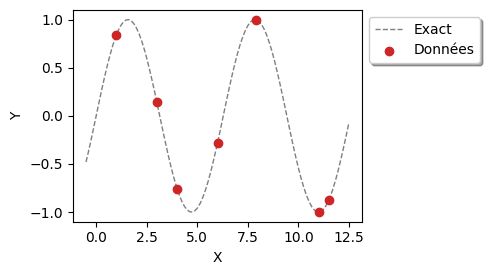

In [7]:
graph = ot.Graph()
graph.add(plotDataTest(xTest, yTest))
graph.add(plotDataTrain(xTrain, yTrain))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
view = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

In [8]:
dimension = 1
basis = ot.ConstantBasisFactory(dimension).build()
covarianceModel = ot.MaternModel([1.0] * dimension, 1.5)
fitter = otexp.GaussianProcessFitter(xTrain, yTrain, covarianceModel, basis)
fitter.run()
gpr = otexp.GaussianProcessRegression(fitter.getResult())
gpr.run()
gprResult = gpr.getResult()
print(gprResult)

GaussianProcessRegressionResult(covariance models=MaternModel(scale=[1.27446], amplitude=[0.822252], nu=1.5), covariance coefficients=0 : [  1.13908    ]
1 : [  1.01757    ]
2 : [ -1.76275    ]
3 : [ -0.559143   ]
4 : [  1.78756    ]
5 : [ -1.6194     ]
6 : [ -0.00292259 ], basis=Basis( [[x0]->[1]] ), trend coefficients=[0.00736634])


In [9]:
gprMetaModel = gprResult.getMetaModel()
yTestMetaModel = gprMetaModel(xTest)

In [10]:
def plotDataGPR(xTest, yTestMetaModel, color="dodgerblue3"):
    """Plots (xTest,yTestMetaModel) from the metamodel as a Curve, in blue"""
    graphK = ot.Curve(xTest, yTestMetaModel)
    graphK.setColor(color)
    graphK.setLegend("PG")
    return graphK

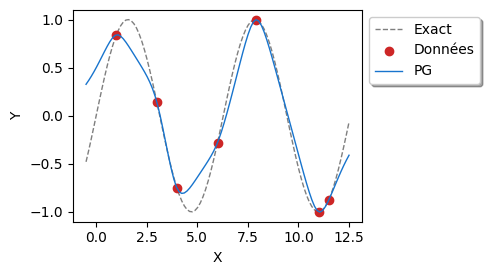

In [11]:
graph = ot.Graph()
graph.add(plotDataTest(xTest, yTest))
graph.add(plotDataTrain(xTrain, yTrain))
graph.add(plotDataGPR(xTest, yTestMetaModel))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
view = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

In [12]:
normalDistribution = ot.Normal()
alpha = 0.05
bilateralCI = normalDistribution.computeBilateralConfidenceInterval(1 - alpha)
print("alpha=%f" % (alpha))
quantileAlpha = bilateralCI.getUpperBound()[0]
print("Quantile alpha=%f" % (quantileAlpha))
gprResult

alpha=0.050000
Quantile alpha=1.959964


class=GaussianProcessRegressionResult, basis=class=Basis coll=[class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,y0] evaluationImplementation=class=ConstantEvaluation name=Unnamed constant=class=Point name=Unnamed dimension=1 values=[1] gradientImplementation=class=ConstantGradient name=Unnamed constant=class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=1 columns=1 values=[0] hessianImplementation=class=NullHessian name=Unnamed inputDimension=1 outputDimension=1], trend coefficients=class=Point name=Unnamed dimension=1 values=[0.00736634], covariance models=class=MaternModel scale=class=Point name=Unnamed dimension=1 values=[1.27446] amplitude=class=Point name=Unnamed dimension=1 values=[0.822252] nu=1.5, covariance coefficients=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=7 dimension=1 data=[[1.13908],[1.01757],[-1.76275],[-0.559143],[1.78756],[-1.6194],[-0.00292259]]

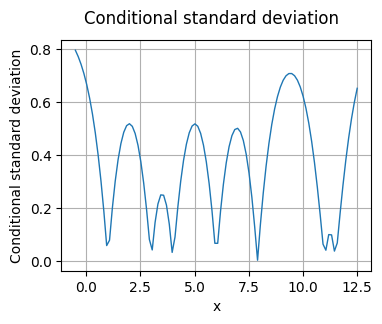

In [13]:
conditional = otexp.GaussianProcessConditionalCovariance(gprResult)
covGrid = conditional.getConditionalMarginalVariance(xTest)
conditionalStDev = np.sqrt(covGrid)
# Plot
graph = ot.Graph(
    "Conditional standard deviation", "x", "Conditional standard deviation", True, ""
)
curve = ot.Curve(xTest, conditionalStDev)
graph.add(curve)
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
view = otv.View(graph, figure_kw={"figsize": (4.0, 3.0)})

Pour créer le graphique des bornes de l'intervalle de confiance, on utilise la classe `Polygon` dans le but de créer une surface colorée associée à l'intervalle de confiance. Pour cela, on commence par générer les sommets des polygones en bas `vLow` et en haut `vUp`. Puis on assemble les sommets pour former les polygônes. 

In [14]:
def plotGPRBounds(
    gprResult, xTest, color="darkorange1", alphaLevel=0.95, alphaTransparency=0.5
):
    """
    Plot normal confidence bounds of a GPR

    Parameters
    ----------
    gprResult : ot.GaussianProcessResult
        The GPR
    xTest : ot.Sample
        The x testing points
    color : hex str
        The color
    alphaLevel : float, in [0, 1]
        The confidence level
    alphaTransparency : float, in [0, 1]
        The transparency

    Returns
    -------
    boundsPoly : ot.PolygonArray
        The colored area.
    """
    conditional = otexp.GaussianProcessConditionalCovariance(gprResult)
    covGrid = conditional.getConditionalMarginalVariance(xTest)
    gprMetaModel = gprResult.getMetaModel()
    yTestMetaModel = gprMetaModel(xTest)
    nTest = xTest.getSize()
    normalDistribution = ot.Normal()
    bilateralCI = normalDistribution.computeBilateralConfidenceInterval(alphaLevel)
    quantileAlpha = bilateralCI.getUpperBound()[0]
    conditionalStDev = np.sqrt(covGrid)
    dataLower = yTestMetaModel - conditionalStDev * quantileAlpha
    dataUpper = yTestMetaModel + conditionalStDev * quantileAlpha
    boundsPoly = ot.Polygon.FillBetween(xTest, dataLower, dataUpper)
    boundsPoly.setLegend("95% bounds")
    boundsPoly.setColor(color)
    boundsPoly.setAlpha(alphaTransparency)
    return boundsPoly

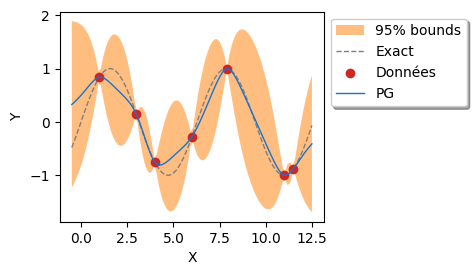

In [15]:
graph = ot.Graph()
graph.add(plotGPRBounds(gprResult, xTest))
graph.add(plotDataTest(xTest, yTest))
graph.add(plotDataTrain(xTrain, yTrain))
graph.add(plotDataGPR(xTest, yTestMetaModel))
graph.setAxes(True)
graph.setXTitle("X")
graph.setYTitle("Y")
graph.setLegendPosition("topright")
graph.setLegendPosition("upper left")
graph.setLegendCorner((1.0, 1.0))
view = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

## Solution de l'exercice 1 : choix du prochain point


Optimize=True


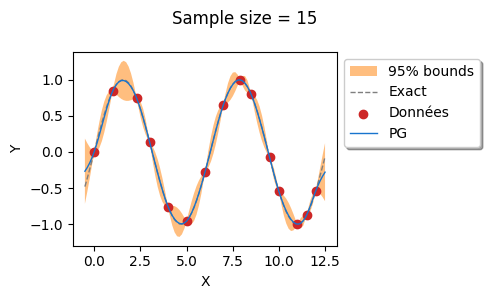

In [16]:
def fitGPR(
    xTrain, yTrain, optimizeParameters=True, covarianceModel=None, nu=1.5, basis=None
):
    """Fit a Gaussian Process Regression model to the provided training data.

    This function configures and trains a kriging model using a constant basis
    and a Matern (3/2) covariance model. It automates the parameter adjustment
    process through the GaussianProcessFitter class to find the optimal
    hyperparameters.

    Parameters
    ----------
    xTrain : openturns.Sample
        The input training sample of dimension 1.
    yTrain : openturns.Sample
        The output training sample (observations) corresponding to the inputs.
    optimizeParameters : bool
        Set to False to disable optimization
    covarianceModel : ot.CovarianceModel
        By default, set a ot.MaternModel([1.0] * dimension, nu)
    nu : float, > 0.5
        The regularity parameter of the Matern covariance model
    basis : ot.Basis
        The basis.
        By default, set a ConstantBasis.

    Returns
    -------
    gprResult : otexp.GaussianProcessRegressionResult
        The object containing the fitting results, including the metamodel and
        the optimized covariance parameters.

    Examples
    --------
    >>> import openturns as ot
    >>> import openturns.experimental as otexp
    >>> X = ot.Sample([[1.0], [2.0], [3.0]])
    >>> Y = ot.Sample([[2.5], [3.7], [5.1]])
    >>> result = fitGPR(X, Y)
    """
    # Covariance model
    dimension = xTrain.getDimension()
    if basis is None:
        basis = ot.ConstantBasisFactory(dimension).build()
    if covarianceModel is None:
        covarianceModel = ot.MaternModel([1.0] * dimension, nu)
    # Fit the GP on the training data
    fitter = otexp.GaussianProcessFitter(xTrain, yTrain, covarianceModel, basis)
    print(f"Optimize={optimizeParameters}")
    fitter.setOptimizeParameters(optimizeParameters)
    fitter.run()
    gpr = otexp.GaussianProcessRegression(fitter.getResult())
    gpr.run()
    gprResult = gpr.getResult()
    return gprResult


def drawGPR(xTrain, yTrain, gprResult, xMin=-0.5, xMax=12.5, nTest=100):
    """Visualize the Gaussian Process Regression results and training data.

    This function creates a comprehensive plot comparing the original model,
    the GPR metamodel, the training data, and the prediction confidence bounds.
    It evaluates the metamodel over a specified range to generate the visual
    representation.

    Parameters
    ----------
    xTrain : openturns.Sample
        The training input samples used for the GPR fit.
    yTrain : openturns.Sample
        The corresponding training output observations.
    gprResult : otexp.GaussianProcessRegressionResult
        The result object from a prior GPR fit containing the metamodel.
    xMin : float, optional
        The lower bound of the plotting range. Default is -0.5.
    xMax : float, optional
        The upper bound of the plotting range. Default is 12.5.
    nTest : int, optional
        The number of points used to discretize the plotting grid. Default is 100.

    Returns
    -------
    graph : openturns.Graph
        A graphical object consolidating the data points, the metamodel curve,
        and the uncertainty intervals.

    Examples
    --------
    >>> import openturns as ot
    >>> # Assuming result is a GaussianProcessRegressionResult object
    >>> graph = drawGPR(X_train, Y_train, result)
    """
    # Create a grid to plot the function and the metamodel
    xTest = linearSample(xMin, xMax, nTest)
    yTest = g(xTest)
    #
    gprMetaModel = gprResult.getMetaModel()
    yTestMetaModel = gprMetaModel(xTest)
    # Plot
    graph = ot.Graph()
    graph.add(plotGPRBounds(gprResult, xTest))
    graph.add(plotDataTest(xTest, yTest))
    graph.add(plotDataTrain(xTrain, yTrain))
    graph.add(plotDataGPR(xTest, yTestMetaModel))
    graph.setAxes(True)
    graph.setXTitle("X")
    graph.setYTitle("Y")
    graph.setTitle(f"Sample size = {xTrain.getSize()}")
    graph.setLegendPosition("upper left")
    graph.setLegendCorner((1.0, 1.0))
    return graph


# xTrain = ot.Sample.BuildFromPoint([1.0, 3.0, 4.0, 6.0, 7.9, 11.0, 11.5, 9.5])  # Etape 1
# xTrain = ot.Sample.BuildFromPoint([1.0, 3.0, 4.0, 6.0, 7.9, 11.0, 11.5, 9.5, 0.0])  # Etape 2
# xTrain = ot.Sample.BuildFromPoint([1.0, 3.0, 4.0, 6.0, 7.9, 11.0, 11.5, 9.5, 0.0, 12.0])  # Etape 3
xTrain = ot.Sample.BuildFromPoint(
    [1.0, 3.0, 4.0, 6.0, 7.9, 11.0, 11.5, 9.5, 0.0, 12.0, 2.3, 5.0, 7.0, 8.5, 10.0]
)  # Etape 4
yTrain = g(xTrain)
gprResult = fitGPR(xTrain, yTrain)
graph = drawGPR(xTrain, yTrain, gprResult)
view = otv.View(graph, figure_kw={"figsize": (5.0, 3.0)})

In [17]:
def getNewPoint(xMin, xMax, gprResult):
    """
    Returns a new point to be added to the design of experiments.
    This point maximizes the conditional variance of the metamodel.
    """
    nbpoints = 50
    xGrid = linearSample(xMin, xMax, nbpoints)
    gpcc = otexp.GaussianProcessConditionalCovariance(gprResult)
    conditionalVariance = gpcc.getConditionalMarginalVariance(xGrid)
    iMaxVar = int(np.argmax(conditionalVariance))
    xNew = xGrid[iMaxVar, 0]
    xNew = ot.Point([xNew])
    return xNew

In [18]:
def createGridFromGraphList(listOfGraphs, numberOfRows=2, numberOfColumns=None):
    """
    Create a GridLayout with given number of rows and columns

    Parameters
    ----------
    listOfGraphs : list(ot.Graph)
        The graphs.
        The number of graphs must be lower or equal than the number of
        grid cells, i.e. numberOfRows x numberOfColumns.
    numberOfRows : int
        The number of rows in the grid.
    numberOfColumns : int
        The number of columns in the grid.

    Returns
    -------
    grid : ot.GridLayout(numberOfRows, numberOfColumns)
        The grid of graphs.
    """
    numberOfGraphs = len(listOfGraphs)
    if numberOfColumns is None:
        numberOfColumns = math.ceil(numberOfGraphs / numberOfRows)
    if numberOfGraphs > numberOfRows * numberOfColumns:
        raise ValueError(
            f"Number of graphs is {numberOfGraphs} "
            f"but nb. rows = {numberOfRows} and nb. columns = {numberOfColumns}"
        )
    grid = ot.GridLayout(numberOfRows, numberOfColumns)
    index = 0
    for i in range(numberOfRows):
        for j in range(numberOfColumns):
            if index >= numberOfGraphs:
                break
            grid.setGraph(i, j, listOfGraphs[index])
            index += 1
    return grid

Optimize=True
Adds x=[-0.5], y=[-0.479426]
Optimize=True
Adds x=[9.31633], y=[0.108239]
Optimize=True
Adds x=[12.5], y=[-0.0663219]
Optimize=True
Adds x=[5.07143], y=[-0.936235]
Optimize=True
Adds x=[1.88776], y=[0.950188]
Optimize=True
Adds x=[6.92857], y=[0.601507]
Optimize=True
Adds x=[10.1122], y=[-0.634582]
Optimize=True


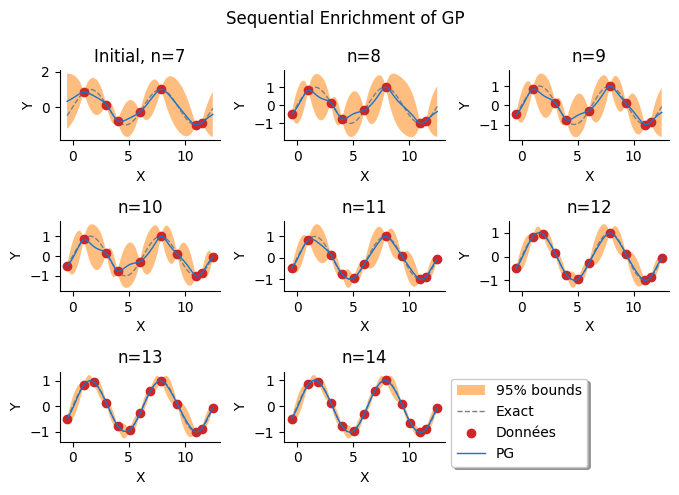

In [19]:
xTrain = ot.Sample.BuildFromPoint([1.0, 3.0, 4.0, 6.0, 7.9, 11.0, 11.5])  # Etape 1
yTrain = g(xTrain)
listOfGraphs = []
# Draw initial training sample
gprResult = fitGPR(xTrain, yTrain)
graph = drawGPR(xTrain, yTrain, gprResult)
graph.setLegends([""])
graph.setTitle(f"Initial, n={xTrain.getSize()}")
listOfGraphs.append(graph)
# Make some steps
numberOfSteps = 7
for step in range(numberOfSteps):
    xNew = getNewPoint(xMin, xMax, gprResult)
    yNew = g(xNew)
    print(f"Adds x={xNew}, y={yNew}")
    xTrain.add(xNew)
    yTrain.add(yNew)
    gprResult = fitGPR(xTrain, yTrain)
    graph = drawGPR(xTrain, yTrain, gprResult)
    graph.setTitle(f"n={xTrain.getSize()}")
    if step < numberOfSteps - 1:
        graph.setLegends([""])
    listOfGraphs.append(graph)

grid = createGridFromGraphList(listOfGraphs, numberOfRows=3)
grid.setTitle("Sequential Enrichment of GP")
view = otv.View(grid, figure_kw={"figsize": (7.0, 5.0)})
plt.subplots_adjust(wspace=0.4)

## Solution de l'exercice 2 : impact de l'estimation des hyperparamètres



Optimize=True
Covariance Scale = [1.48067]
Covariance Amplitude = [0.795093]
Optimize=False
Covariance Scale = [1]
Covariance Amplitude = [1]


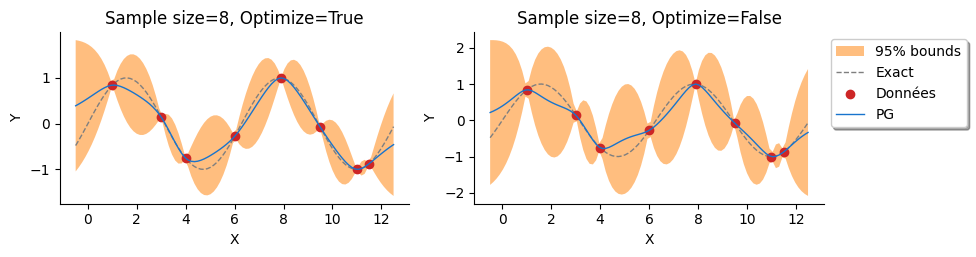

In [20]:
def fitAndDrawGPR(xTrain, xMin=-0.5, xMax=12.5, nTest=100, optimizeParameters=True):
    g = ot.SymbolicFunction(["x"], ["sin(x)"])
    yTrain = g(xTrain)
    gprResult = fitGPR(xTrain, yTrain, optimizeParameters=optimizeParameters)
    optimizedCovarianceModel = gprResult.getCovarianceModel()
    print(f"Covariance Scale = {optimizedCovarianceModel.getScale()}")
    print(f"Covariance Amplitude = {optimizedCovarianceModel.getAmplitude()}")
    # Plot
    graph = drawGPR(xTrain, yTrain, gprResult, xMin=xMin, xMax=xMax, nTest=nTest)
    graph.setTitle(f"Sample size={xTrain.getSize()}, " f"Optimize={optimizeParameters}")
    return graph


xTrain = ot.Sample.BuildFromPoint([1.0, 3.0, 4.0, 6.0, 7.9, 11.0, 11.5, 9.5])  # Etape 1
grid = ot.GridLayout(1, 2)
# Avec optimisation
graph = fitAndDrawGPR(xTrain, optimizeParameters=True)
graph.setLegends([""])
grid.setGraph(0, 0, graph)
# Sans optimisation
graph = fitAndDrawGPR(xTrain, optimizeParameters=False)
grid.setGraph(0, 1, graph)
view = otv.View(grid, figure_kw={"figsize": (10.0, 3.0)})

On observe que les lobes de confiance sont un peu plus petits lorsqu'on optimise les hyperparamètres. On observe aussi que cette amélioration n'est pas radicale : l'optimisation des hyperparamètres est moins déterminante dans ce cas que le positionnement des points.

## Solution de l'exercice 3 : impact du modèle de covariance


Optimize=True
Covariance Scale = [1.0457]
Covariance Amplitude = [0.740785]
Optimize=True
Covariance Scale = [1.48067]
Covariance Amplitude = [0.795093]
Optimize=True
Covariance Scale = [1.58111]
Covariance Amplitude = [0.829987]
Optimize=True
Covariance Scale = [1.61963]
Covariance Amplitude = [0.897622]


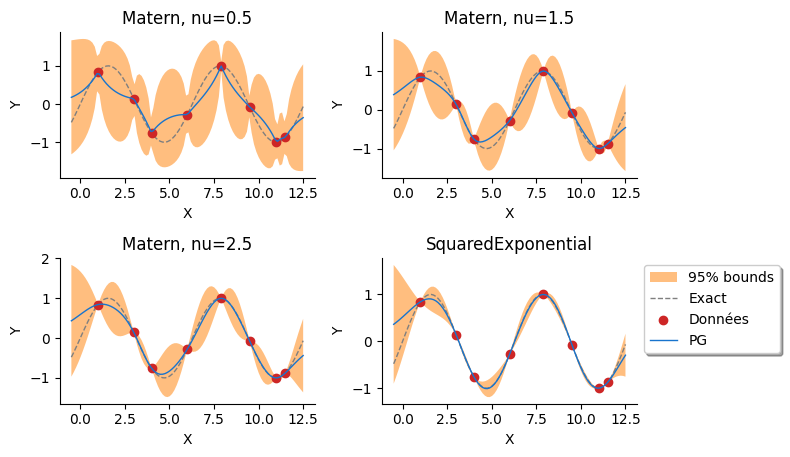

In [21]:
def fitAndDrawGPRFromCovarianceModel(
    xTrain, covarianceModel, xMin=-0.5, xMax=12.5, nTest=100, optimizeParameters=True
):
    g = ot.SymbolicFunction(["x"], ["sin(x)"])
    yTrain = g(xTrain)
    gprResult = fitGPR(xTrain, yTrain, covarianceModel=covarianceModel)
    optimizedCovarianceModel = gprResult.getCovarianceModel()
    print(f"Covariance Scale = {optimizedCovarianceModel.getScale()}")
    print(f"Covariance Amplitude = {optimizedCovarianceModel.getAmplitude()}")
    # Plot
    graph = drawGPR(xTrain, yTrain, gprResult, xMin=xMin, xMax=xMax, nTest=nTest)
    graph.setTitle(
        f"Sample size={xTrain.getSize()}, "
        f"Optimize={optimizeParameters}, "
        f"{covarianceModel}"
    )
    return graph


xTrain = ot.Sample.BuildFromPoint([1.0, 3.0, 4.0, 6.0, 7.9, 11.0, 11.5, 9.5])  # Etape 1
listOfGraphs = []
# Avec Matérn
for nu in [0.5, 1.5, 2.5]:
    covarianceModel = ot.MaternModel([1.0], nu)
    graph = fitAndDrawGPRFromCovarianceModel(xTrain, covarianceModel)
    graph.setTitle(f"Matern, nu={nu:.1f}")
    graph.setLegends([""])
    listOfGraphs.append(graph)
# Avec SquaredExponential
covarianceModel = ot.SquaredExponential([1.0])
graph = fitAndDrawGPRFromCovarianceModel(xTrain, covarianceModel)
graph.setTitle(f"SquaredExponential")
listOfGraphs.append(graph)
grid = createGridFromGraphList(listOfGraphs)
view = otv.View(grid, figure_kw={"figsize": (8.0, 5.0)})

On observe que l'espérance conditionnelle du krigeage associé au modèle de Matérn 1/2 est plutôt irrégulière : bien que le modèle interpole les données, l'espérance conditionnelle n'est pas dérivable. Plus précisément, on observe distinctement que la dérivée à gauche de chaque point est différente de la dérivée à droite. Le métamodèle est plus régulier avec le paramètre de régularité $\nu=3/2$ et très régulière avec $\nu=5/2$. Les meilleurs résultats sont produits avec le modèle exponentiel carré. C'est le résultat attendu, puisque la fonction $\sin(x)$ est infiniment dérivable.